In [1]:
import os
import warnings
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display
from typing import List

# 환경 설정
load_dotenv()
warnings.filterwarnings("ignore")

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\langchain-basic-kGdHTiMZ-py3.12\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:

# Vector DB 초기화 (카페 메뉴 DB)
embeddings_model = OllamaEmbeddings(model="bge-m3:latest")
cafe_db = FAISS.load_local(
    "./db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# 1단계: 카페 메뉴 검색 도구 정의
@tool
def search_cafe_menu(query: str) -> str:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = cafe_db.similarity_search(query, k=6)
    
    formatted_docs = "\n\n---\n\n".join([
        f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
        for doc in docs
    ])
    
    if len(docs) > 0:
        return formatted_docs
    return "관련 카페 메뉴 정보를 찾을 수 없습니다."

# 2단계: 상태 정의
class AgentState(MessagesState):
    """ReAct Agent의 상태를 정의하는 클래스"""
    pass

In [3]:

# 3단계: LLM과 도구 설정
#llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
llm = ChatOpenAI(
    #api_key=OPENAI_API_KEY,
    base_url="https://api.groq.com/openai/v1",  # Groq API 엔드포인트
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0.7
)

tools = [search_cafe_menu]
llm_with_tools = llm.bind_tools(tools=tools)

# 4단계: 시스템 프롬프트 정의
system_prompt = """
당신은 카페의 AI 어시스턴트입니다. 고객의 메뉴 관련 질문에 정확하고 친절하게 답변해주세요.

다음 도구를 사용할 수 있습니다:
- search_cafe_menu: 카페 메뉴 정보를 검색할 때 사용하세요

고객의 질문을 이해하고, 필요한 경우 도구를 사용하여 정보를 찾은 후 정확한 답변을 제공하세요.
"""

# 5단계: 노드 함수들 정의
def call_model(state: AgentState):
    """LLM을 호출하여 응답을 생성하는 노드"""
    print("--- Agent 노드: LLM 호출 ---")
    
    # 시스템 메시지 추가
    messages = [SystemMessage(content=system_prompt)] + state['messages']
    response = llm_with_tools.invoke(messages)
    
    print(f"LLM 응답 생성 완료. 도구 호출 여부: {bool(response.tool_calls)}")
    
    return {"messages": [response]}

In [4]:

# 6단계: 그래프 구성
builder = StateGraph(AgentState)

# 노드 추가
builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

# 엣지 추가
builder.add_edge(START, "agent")

# 조건부 엣지: tools_condition 사용
builder.add_conditional_edges(
    "agent",
    tools_condition,  # 자동으로 도구 호출 여부 판단
)

# 도구 실행 후 다시 agent로 돌아가기
builder.add_edge("tools", "agent")

# 7단계: 그래프 컴파일
custom_react_agent = builder.compile()

print("사용자 정의 ReAct Agent가 성공적으로 생성되었습니다!")
print(f"Agent 타입: {type(custom_react_agent)}")

사용자 정의 ReAct Agent가 성공적으로 생성되었습니다!
Agent 타입: <class 'langgraph.graph.state.CompiledStateGraph'>


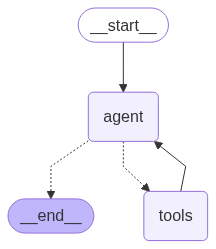

In [5]:
# 8단계: 그래프 시각화
try:
    display(Image(custom_react_agent.get_graph().draw_mermaid_png()))
except:
    print("그래프 시각화를 건너뜁니다.")

In [6]:

# 9단계: Agent 테스트 함수
def test_custom_react_agent():
    """사용자 정의 ReAct Agent 테스트"""
    test_questions = [
        "아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.",
        "라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?",
        "디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요."
    ]
    
    for question in test_questions:
        print(f"\n{'='*60}")
        print(f"질문: {question}")
        print('='*60)
        
        # Agent 실행
        inputs = {"messages": [HumanMessage(content=question)]}
        result = custom_react_agent.invoke(inputs)
        
        # 실행 과정 출력
        print("\n=== 실행 과정 ===")
        for i, message in enumerate(result['messages']):
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"{i+1}. {type(message).__name__}: 도구 호출 - {message.tool_calls[0]['name']}")
            else:
                content_preview = message.content[:100] + "..." if len(message.content) > 100 else message.content
                print(f"{i+1}. {type(message).__name__}: {content_preview}")
        
        # 최종 답변 출력
        print(f"\n=== 최종 답변 ===")
        print(result['messages'][-1].content)

In [7]:

# 10단계: 단일 테스트 실행
print("\n=== 단일 테스트 ===")
inputs = {"messages": [HumanMessage(content="콜드브루와 아이스 아메리카노의 차이점이 무엇인가요?")]}
result = custom_react_agent.invoke(inputs)

print("\n=== 메시지 흐름 분석 ===")
for i, message in enumerate(result['messages']):
    print(f"{i+1}. {type(message).__name__}")
    if hasattr(message, 'tool_calls') and message.tool_calls:
        print(f"   - 도구 호출: {message.tool_calls[0]['name']} with '{message.tool_calls[0]['args']['query']}'")
    else:
        content_preview = message.content[:150] + "..." if len(message.content) > 150 else message.content
        print(f"   - 내용: {content_preview}")

print(f"\n=== 최종 답변 ===")
print(result['messages'][-1].content)

# 11단계: 전체 테스트 실행
print("\n=== 전체 테스트 실행 ===")
test_custom_react_agent()


=== 단일 테스트 ===
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: True
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: False

=== 메시지 흐름 분석 ===
1. HumanMessage
   - 내용: 콜드브루와 아이스 아메리카노의 차이점이 무엇인가요?
2. AIMessage
   - 도구 호출: search_cafe_menu with '엄또 아이스 아메리사노의 챑이점'
3. ToolMessage
   - 내용: <Document source="../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 차가운 물, 얼음
   • 설명: 진한 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 아이스 ...
4. AIMessage
   - 내용: 콜드브루는 메뉴에 없습니다. 하지만 아이스 아메리카노는 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 커피입니다. 깔끔하고 시원한 맛이 특징이며, 원두 본연의 풍미를 느낄 수 있습니다. 더운 날씨에 인기가 높습니다. 가격은 \u4,500입니다.

=== 최종 답변 ===
콜드브루는 메뉴에 없습니다. 하지만 아이스 아메리카노는 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 커피입니다. 깔끔하고 시원한 맛이 특징이며, 원두 본연의 풍미를 느낄 수 있습니다. 더운 날씨에 인기가 높습니다. 가격은 \u4,500입니다.

=== 전체 테스트 실행 ===

질문: 아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: True
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: False

=== 실행 과정 ===
1. HumanMessage: 아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
2. AIMess